### Warning:

Please assume that this is still a work in progress, hence code is likely messey, superfluous, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/yob_ss/yob1880.txt', header=None,
                names = ['first', 'sex', 'count'])

#Per old actuarial methods I used, we'll be defining Male as anything not Female. Albeit even in 2023 all binary.
newborn_females, newborn_males = sum(df[df['sex']=='F']['count']), sum(df[df['sex']!='F']['count'])
df['per_of_year'] = [round(i/newborn_females, 3) if sex == 'F' else round(i/newborn_males, 3) for i, sex in zip(df['count'], df['sex'])]
male_name_start = df['sex'].value_counts()['F']
df['rank_of_year'] = [i if sex == 'F' else i - male_name_start for i, sex in zip(range(1, df.shape[0]+1), df['sex'])]
print(df.shape)

df.head()

#Hmm, potentally change the last two columns to make it clearer that it's gender specific? Oh well

(2000, 5)


,first,sex,count,per_of_year,rank_of_year
0,Mary,F,7065,0.078,1
1,Anna,F,2604,0.029,2
2,Emma,F,2003,0.022,3
3,Elizabeth,F,1939,0.021,4
4,Minnie,F,1746,0.019,5


Even if a name is androgynous, we're still intersted in seeing hte percentage of whatever gender being called it, to gauge name usage over time. Hence, depending upon the gender dividing a 'male' or 'female' name by the sum of all male/fe names used in whatever year.

In [3]:
#Hmm, but we have a gazillion... I see two approaches:
#Make a giant data frame and add all those guys to it, seperating them via year.

#2 Have a gazillion dataframes thenmaybe add as needed.

#Yeah, we're doing the former.

#Just realzied that we're assuming the SS lists are oganized by count. Perhaps we should be strict... oh well

birth_years = []

for specific_year in range(1880, 2024):
    curr_df = pd.read_csv(f'../data/yob_ss/yob{specific_year}.txt', header=None,
                names = ['first', 'sex', 'count'])
    curr_df['year'] = specific_year
    newborn_females, newborn_males = sum(curr_df[curr_df['sex']=='F']['count']), sum(curr_df[curr_df['sex']!='F']['count'])
    curr_df['per_of_year'] = [round(i/newborn_females, 3) if sex == 'F' else round(i/newborn_males, 3) for i, sex in zip(curr_df['count'], curr_df['sex'])]
    male_name_start = curr_df['sex'].value_counts()['F']
    curr_df['rank_of_year'] = [i if sex == 'F' else i - male_name_start for i, sex in zip(range(1, curr_df.shape[0]+1), curr_df['sex'])]
    birth_years.append(curr_df)
    
df = pd.concat(birth_years, axis=0, ignore_index=True) #Apparently it's faster to do it this way. More intuitive to be to
#update the 'final' df immediately, but at least upon asking ChatGPT they claim it's quicker this way. Although we only have
#4 features, including year, we do have over 2m records.
    
print(df.shape)
df.head()

(2117219, 6)


,first,sex,count,year,per_of_year,rank_of_year
0,Mary,F,7065,1880,0.078,1
1,Anna,F,2604,1880,0.029,2
2,Emma,F,2003,1880,0.022,3
3,Elizabeth,F,1939,1880,0.021,4
4,Minnie,F,1746,1880,0.019,5


Hmm, I'm wondering if SQL might have been the way to go for this. Eh, oh well.

In [4]:
df[(df['sex'] == 'M') & (df['year'] < 1900)].sort_values('count', ascending=False)[:10]

,first,sex,count,year,per_of_year,rank_of_year
942,John,M,9655,1880,0.087,1
4962,John,M,9557,1882,0.084,1
943,William,M,9532,1880,0.086,2
9317,John,M,9388,1884,0.082,1
4963,William,M,9298,1882,0.082,2
18975,John,M,9247,1888,0.077,1
29758,John,M,9039,1892,0.074,1
14018,John,M,9026,1886,0.081,1
9318,William,M,8897,1884,0.078,2
7115,John,M,8894,1883,0.085,1


In [5]:
df['sex'].value_counts() #Wow.... and who said it's 50/50?!!?!? Not even close.... perhaps in one year is different
#Oh no noob - this refers to just names... we'd need to sum the counts...

#Still interesting though... albeit many are duplicated

sex
F    1245559
M     871660
Name: count, dtype: int64

In [6]:
len(df[df['sex']=='F']['first'].unique()), len(df[df['sex']!='F']['first'].unique()) #There we go. Hmm, a similar disparity,
#which somewhat makes sense.Regardless, see the much greater varity of female names than male names. Now, recall we're dealing
#with the United States - a country that has many immigrants coming in, more and more as time goes on.So, a bit harder to gauge
#the proportion of names when certain cultures bring with it differnt proportions of the gendered names.

(70903, 44261)

In [7]:
#Now, this is what I meant to do:

females, males = sum(df[df['sex']=='F']['count']), sum(df[df['sex']!='F']['count'])
females,males
#Hmm, so about 4 million more males born over 144 years. Interesting. Might be neat to do a thing where we log
#the number of males/females born each year from 1880 to 2023, potetialy focusing on percentages to cancel the effect of population
#growth.

(182299206, 186337032)

In [8]:
round(females/len(df[df['sex']=='F']['first'].unique()), 3), round(males/len(df[df['sex']!='F']['first'].unique()), 3)
#Wow, the average female name is used a bit more than half of the average male name. Obviously from just our head we see Mary and Anna
#beat that - just with that one year... but we're talking about all 70k unique female names...

(2571.107, 4209.96)

In [9]:
df[df['year'] == 1880]['sex'].value_counts()

sex
M    1058
F     942
Name: count, dtype: int64

## Select Analytics and Visuals

Hmm, what should we focus on? I'll at least give 3 ideas right now:

Note, by default assume things are gendered (do it both for male and female)

Most popular name from 1880 useage until now.
    From 2023 and how it changes (if it did)
Occurences of names in the top 10, 20, 25, 30, 50, 100

Gendered births over time (ie did begetting males become less frequent?)

In [10]:
birth_percentages = []
for i in range(1880, 2024): #Od
    females, males = sum(df[(df['year'] == i) & (df['sex'] == 'F')]['count']), sum(df[(df['year'] == i) & (df['sex'] != 'F')]['count'])
    births = females + males
    birth_percentages.append([i, round(females/births, 3), round(males/births, 3)])
    
birth_percentages = pd.DataFrame(birth_percentages, columns=['year', 'female_br', 'male_br'])
birth_percentages.head()

,year,female_br,male_br
0,1880,0.452,0.548
1,1881,0.477,0.523
2,1882,0.487,0.513
3,1883,0.518,0.482
4,1884,0.530,0.470


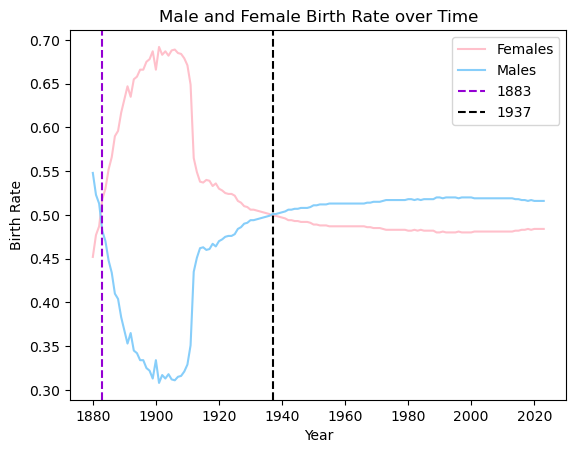

In [11]:
xtitle = 'Year'
ytitle = 'Birth Rate'
title = 'Male and Female Birth Rate over Time'

plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.title(title)
plt.plot(birth_percentages['year'], birth_percentages['female_br'], color = 'pink', label = 'Females')
plt.plot(birth_percentages['year'], birth_percentages['male_br'], color = 'lightskyblue', label = 'Males')
plt.axvline(x=1883, color='darkviolet', linestyle='--', label='1883') #Found via eda
plt.axvline(x=1937, color='black', linestyle='--', label='1937')
plt.legend();

Yeah, all this adds to a lot of interestng discussions, especially in years 1889 to 1911 that the female birthrate was over 20% that of males, maxing out at 69.2% to 30.8% in 1901.

Pragmatically recall I trend I remember from my actuarial days where apparently the expected age difference was that males would be 3 years older than females. So, on a population basis we might need to offset them by three, but eh...

In [12]:
# birth_percentages[birth_percentages['female_br']-birth_percentages['male_br']>.2]
# birth_percentages[birth_percentages['female_br']==birth_percentages['female_br'].max()]

In [13]:
#Re the unique names - I think it's better to contrast just two years than to do another line graph. I think it'll better
#emphasis the change over time.

#Hmm, should I be writing a formula for this? Eh, at least at the moment... So close to having that though when I have the years
#out in front.

y1 = 1880
y2 = 2023

y1_u_fnames, y1_u_mnames = df[(df['year']==y1)&(df['sex']=='F')].shape[0], df[(df['year']==y1)&(df['sex']!='F')].shape[0] #Perhaps should do count, but eh
y2_u_fnames, y2_u_mnames = df[(df['year']==y2)&(df['sex']=='F')].shape[0], df[(df['year']==y2)&(df['sex']!='F')].shape[0]

y1_avg_fname, y1_avg_mname = df[(df['year']==y1)&(df['sex']=='F')]['count'].mean(), df[(df['year']==y1)&(df['sex']!='F')]['count'].mean()
y2_avg_fname, y2_avg_mname = df[(df['year']==y2)&(df['sex']=='F')]['count'].mean(), df[(df['year']==y2)&(df['sex']!='F')]['count'].mean()

y1_females, y1_males = df[(df['year']==y1)&(df['sex']=='F')]['count'].sum(), df[(df['year']==y1)&(df['sex']!='F')]['count'].sum()
y2_females, y2_males = df[(df['year']==y2)&(df['sex']=='F')]['count'].sum(), df[(df['year']==y2)&(df['sex']!='F')]['count'].sum()

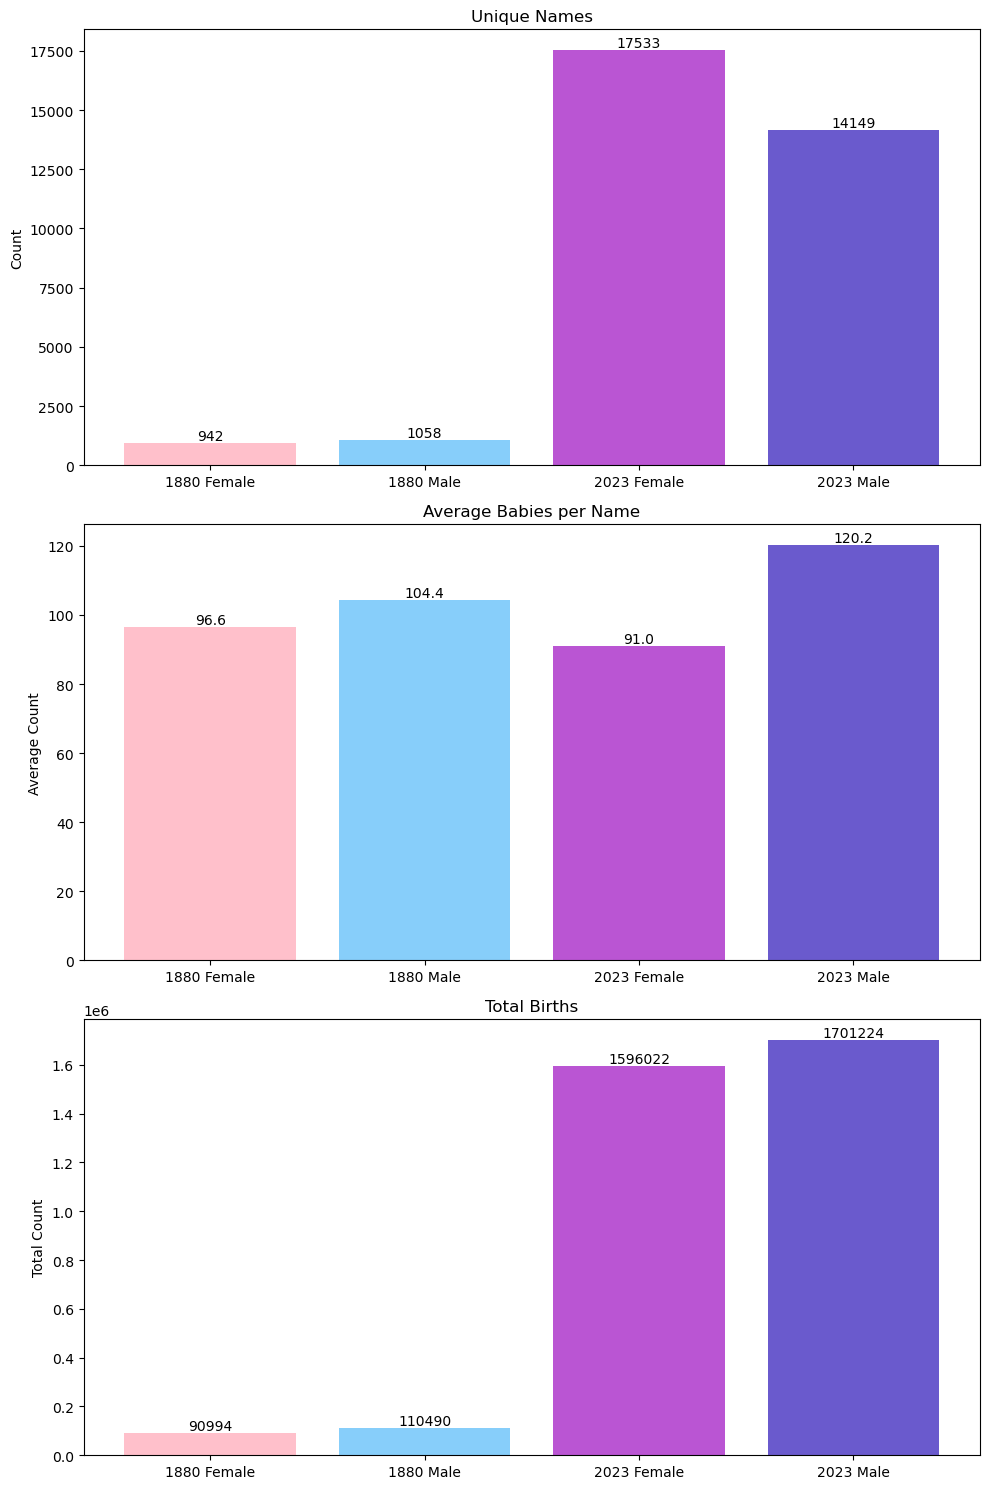

In [36]:
#Honestly tinkered out with ChatGPT. I at least take pride in making the cod as dense as I thought I could.

colors = ['pink', 'lightskyblue', 'mediumorchid', 'slateblue']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

data = [
    ([y1_u_fnames, y1_u_mnames, y2_u_fnames, y2_u_mnames], 'Unique Names', 'Count'),
    ([y1_avg_fname, y1_avg_mname, y2_avg_fname, y2_avg_mname], 'Average Babies per Name', 'Average Count'),
    ([y1_females, y1_males, y2_females, y2_males], 'Total Births', 'Total Count')
]

for ax, (values, title, ylabel) in zip(axs, data):
    bars = ax.bar([f'{y1} Female', f'{y1} Male', f'{y2} Female', f'{y2} Male'], values, color=colors)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval) if ylabel == 'Count' or ylabel == 'Total Count' else round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show();

Anyways, now that the graphs done let's analyze:

When it comes to unique names, females were far less than males in 1880 with that trend changing in 2023 to see quite a significant increase of unique female names to males.

However, it's surprising that when it would come to the average amount of times a name is used, which in retrospect perhaps we should have used the median (but we'll keep matters simple for now at least), the 1880 male name is only negligibly larger than the female name (see below for relative fe/male births and of course the distribution of names which at least as of yet we did not display). In 2023 the trend is as expected where the higher amount of unique female names leads to a lower average amount of females called by said name. Of interest is the disparity though - for every 3 females with the same name (2023) 4 males have the same first name! Such a difference beckons to be examined more in-indepth.

Finally, the total populaton of female and male births in 1880 and 2023 are shown. In both of those years more males are born (see earlier for the propriton throughout time), yet the difference is actually much greater in 1880 than 2023. Although it's beyond the scope of this project, if our analysis is correct thus far - why oh why did rates flucture so much over time? Are men from certain cultures more likely to give birth to daughters, contributing to the bizaare trend noted above?

Although potentially controversial, the reason why I mentioned that is as follows: Upon looking at the population increase, approximately 16x from 1880 to 2023, unique names, particularly among females, proportionally exploded. However, this begs an explanation: Where did all these names come from? Although I think it's reasonable to assume new names within a culture can get added over time, but that many?? Rather, the reasonable assumption is to assume that immigrants added that many new names to the lexicon of baby names. Yet that may?? Then again, the world is a fairly large place... Properly diligance is called for to exame the proportion of trends given. It would seem that in 1880 the USA was likely of a much more monolithic cultural and religious nation and it would be expected that the proprtion of names was much more "even" and distrubted amount the lower-end tail than it is now. So, let us not be lazy and look into that later.

A potential factor to analyze, unavailable to us, is the average family size. I would assume most fathers do not follow the trend of George Foreman, naming all of their sons the same name, save a numerial and later nickname to distinguish them. Of special interest is George VI, "Little Joey", whose nickname includes an actual other name, as opposed to his brothers: "Jr.", "Monk", "Big Wheel", and "Red". Interestingly, he gave his seven daughters all unique names, giving only the fifth the female equivelant: Georgetta (https://en.wikipedia.org/wiki/George_Foreman).